In [1]:
cd dataset

C:\Users\Miya\Desktop\cna\dataset


In [590]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('repositories_refined.csv',parse_dates=['Month, Day, Year of Date'])
#data = data[data['Coding Effort']!=0]
data.columns= ['Worker ID','Repository ID','Coding Effort','Month, Day, Year of Date']

In [591]:
data.head()

,Worker ID,Repository ID,Coding Effort,"Month, Day, Year of Date"
0,aaa,AAA,0.00,2015-07-01
1,dxw,HEL,5.00,2015-07-01
2,woe,WHS,4.73,2015-07-01
3,woe,EZR,0.26,2015-07-01
4,wlk,RJA,5.00,2015-07-01


In [626]:
X_test = data[data['Month, Day, Year of Date']>='2015-08-31']
X_train = data[data['Month, Day, Year of Date']<'2015-08-31']

In [627]:
print(X_train.shape)
print(X_test.shape)

(113034, 4)
(59320, 4)


In [628]:
deve_nodes_train = list(set(X_train.values[:,0]))
deve_nodes_test = list(set(X_test.values[:,0]))

In [629]:
X_test = X_test[X_test['Worker ID'].isin([test for test in deve_nodes_test if test in deve_nodes_train])]

In [630]:
X_test = X_test.groupby(['Worker ID','Repository ID']).sum().reset_index()

In [631]:
t1 = pd.DataFrame(X_train['Worker ID']+X_train['Repository ID'],columns = ['temp'])
t2 = pd.DataFrame(X_test['Worker ID']+X_test['Repository ID'],columns = ['temp'])

In [632]:
X_test = X_test[~t2['temp'].isin(t1['temp'])]

In [633]:
X_train = X_train.groupby(['Worker ID','Repository ID']).sum().reset_index().values

In [634]:
popular_rs = data[data['Month, Day, Year of Date']<'2015-09-21'].groupby(['Worker ID',
                                                             'Repository ID']).count()['Coding Effort'].reset_index().groupby('Worker ID').head(6)

In [635]:
popular_rs = popular_rs.sort_values(['Worker ID','Coding Effort'],ascending =False)

In [636]:
popular_rs[popular_rs['Worker ID'].isin(to_predict_deve)]
popular_rs_list = []

for dev in to_predict_deve:
    popular_rs_list.append(list(popular_rs[popular_rs['Worker ID']==dev]['Repository ID'].values))

In [637]:
X_test.shape[0]/X_train.shape[0]

0.15922977226439547

In [602]:
X_train

array([['aaa', 'AAA', 0.0],
       ['aah', 'KNU', 0.0],
       ['aaj', 'NLY', 70.05],
       ..., 
       ['zzr', 'LWW', 35.959999999999994],
       ['zzs', 'XWQ', 215.31],
       ['zzu', 'QCN', 51.730000000000004]], dtype=object)

In [638]:
actual_list = []
to_predict_deve = set(X_test['Worker ID'])
print(len(to_predict_deve))
for dev in to_predict_deve:
    repo = X_test[X_test['Worker ID']==dev]['Repository ID'].values
    actual_list.append(list(repo))

431


In [639]:
print(len(to_predict_deve))

431


In [640]:
import networkx as nx
%matplotlib inline
from networkx.algorithms import bipartite
G_train = nx.Graph()
for i,v,j in zip(X_train[:,0],X_train[:,1],X_train[:,2]):
    G_train.add_edge(i,v,weight = j)

In [641]:
nx.write_gml(G_train,'g_2.gml')

In [643]:
deve_nodes = list(set(X_train[:,0]))

def normalize(x):
    if x==0:
        x = 1
    else:
        x
    return x

def my_weight(G_train, u, v, weight='weight'):
    w = 0
    for nbr in set(G_train[u]) & set(G_train[v]):
        u_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[u].values()))))
        v_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[v].values()))))
        nbr_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[nbr].values()))))
        
        w += (G_train.edge[u][nbr].get(weight,1)/u_sum) * (G_train.edge[v][nbr].get(weight,1)/nbr_sum)
        return w 
    
    
def jaccard(G, u, v):
    unbrs = set(G[u])
    vnbrs = set(G[v])
    return float(len(unbrs & vnbrs)) / len(unbrs)
    

In [664]:
pd.read_csv('assign.csv').set_index('nodes').head()

,ml_member,info_member,wt_member,fg_member,lp_member,kmeans
nodes,,,,,,
aaa,1,469,258,305,1,25
aah,2,463,164,306,2,0
aaj,387,161,253,63,3,0
aaq,348,1,259,47,4,27
aau,234,351,258,43,5,3


In [665]:
import itertools
def neighbors_cluster(node):
    
    refer = pd.read_csv('assign.csv').set_index('nodes')    
    ml = refer.ix[node,0]
    info = refer.ix[node,1]
    wt = refer.ix[node,2]
    fg = refer.ix[node,3]
    lp = refer.ix[node,4]
    kmeans = refer.ix[node,5]
    
    ml_nn = refer[refer['ml_member']==ml].index
    wt_nn = refer[refer['wt_member']==wt].index
    info_nn = refer[refer['info_member']==info].index
    fg_nn = refer[refer['fg_member']==fg].index
    lp_nn = refer[refer['lp_member']==lp].index
    kmeans_nn = refer[refer['kmeans']==kmeans].index
    
    cluster_nn = list(itertools.chain(wt_nn,kmeans_nn,lp_nn,fg_nn)) #ml_nn,info_nn
    
    return cluster_nn

In [666]:
def neighbors_cluster_weighted(node):
    
    refer = pd.read_csv('assign.csv').set_index('nodes')
    
    ml = refer.ix[node,0]
    info = refer.ix[node,1]
    wt = refer.ix[node,2]
    fg = refer.ix[node,3]
    lp = refer.ix[node,4]
    kmeans = refer.ix[node,5]
    
    ml_nn = refer[refer['ml_member']==ml].index
    wt_nn = refer[refer['wt_member']==wt].index
    info_nn = refer[refer['info_member']==info].index
    fg_nn = refer[refer['fg_member']==fg].index
    lp_nn = refer[refer['lp_member']==lp].index
    kmeans_nn = refer[refer['kmeans']==kmeans].index
    

    
    return wt_nn,kmeans_nn,ml_nn,info_nn,fg_nn,lp_nn

In [667]:
K = 100
def limit_k(rs_list, k = K):
    if len(rs_list)<k:
        return rs_list
    else:
        return rs_list[:k]  

In [668]:
def ensemble_similarity(node,wf):
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    cluster_nn = neighbors_cluster(node)
    
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*np.exp(we)

        
    for nn in cluster_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*1
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [669]:
def community_weight():
    df = pd.read_csv('assign.csv').set_index('nodes')
    wt_w = len(df['wt_member'].unique())/100
    ml_w = len(df['ml_member'].unique())/100
    info_w = len(df['info_member'].unique())/100
    fg_w = len(df['fg_member'].unique())/100
    lp_w = len(df['lp_member'].unique())/100
    
    return wt_w,ml_w,info_w,fg_w,lp_w

In [670]:
def ensemble_similarity_weighted(node,wf):
    
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    
    wt_nn,kmeans_nn,ml_nn,info_nn,fg_nn,lp_nn = neighbors_cluster_weighted(node)
    
    wt_w,ml_w,info_w,fg_w,lp_w = community_weight()
     
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*np.exp(we)

        
    for nn in wt_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*wt_w

    for nn in ml_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*ml_w

    for nn in info_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*info_w
            
    for nn in kmeans_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*30/100
            
    for nn in fg_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*fg_w
            
    for nn in lp_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*lp_w
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [671]:
def projection_similarity(node,wf):
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    cluster_nn = neighbors_cluster(node)
    
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*np.exp(we)
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [672]:
def cluster_similarity(node):
    
    dict_rs = dict()
    cluster_nn = neighbors_cluster(node)

    for nn in cluster_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [673]:
def cluster_similarity_weighted(node):
    
    dict_rs = dict()
    
    wt_nn,kmeans_nn,ml_nn,info_nn,fg_nn,lp_nn = neighbors_cluster_weighted(node)
    
    wt_w,ml_w,info_w,fg_w,lp_w = community_weight()

    for nn in wt_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*wt_w

    for nn in ml_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*ml_w

    for nn in info_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*info_w
            
    for nn in kmeans_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*30/100
            
    for nn in fg_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*fg_w
            
    for nn in lp_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*lp_w
        
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [674]:
def similarity_rs(node_list, method = "projection_similarity",wf = my_weight):
    
    dict_rs = dict()
    for node in node_list:
        if method == 'projection_similarity':
             rs_list = projection_similarity(node,wf)
        if method == 'cluster_similarity':
             rs_list = cluster_similarity(node)
        if method == 'cluster_similarity_weighted':
             rs_list = cluster_similarity_weighted(node)
        if method == 'ensemble_similarity_weighted':
             rs_list = ensemble_similarity_weighted(node,wf)
        if method == 'ensemble_similarity':
             rs_list = ensemble_similarity(node,wf)
        if method == 'ensemble_similarity_weighted_half':
            rs_list1 = cluster_similarity_weighted(node)
            rs_list1 = limit_k(rs_list1, k = 2)
            rs_list2 = projection_similarity(node,wf)
            rs_list2 = limit_k(rs_list2, k = 4)
            rs_list = rs_list1 + rs_list2
            
    
        dict_rs[node] = rs_list
    
    return dict_rs

In [675]:
def apk(actual, predicted, k= K):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual_list, predicted_list, k= 20):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
            
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual_list, predicted_list)])

In [676]:
y_predict_dict_p = similarity_rs(to_predict_deve, method = "projection_similarity",wf = my_weight)

In [677]:
y_predict_dict_p_j = similarity_rs(to_predict_deve, method = "projection_similarity",wf = jaccard)

In [678]:
y_predict_dict_c = similarity_rs(to_predict_deve, method = "cluster_similarity",wf = my_weight)

In [679]:
y_predict_dict_cw = similarity_rs(to_predict_deve, method = "cluster_similarity_weighted",wf = my_weight)

In [680]:
y_predict_dict_e = similarity_rs(to_predict_deve, method = "ensemble_similarity",wf = my_weight)

In [681]:
y_predict_dict_e_w = similarity_rs(to_predict_deve, method = "ensemble_similarity_weighted",wf = my_weight)

In [682]:
y_predict_dict_e_w_h = similarity_rs(to_predict_deve, method = "ensemble_similarity_weighted_half",wf = my_weight)

In [683]:
len(to_predict_deve)

431

In [685]:
actual_list

[['LEG'],
 ['JSQ'],
 ['SAA'],
 ['KEN'],
 ['UXF'],
 ['JMR'],
 ['EZU', 'MRR'],
 ['GVD'],
 ['LPC', 'NQN', 'WLS'],
 ['FKJ'],
 ['TZA'],
 ['VBQ', 'VGL'],
 ['NIK', 'QKF', 'QLP'],
 ['FAB', 'YCS'],
 ['UWL'],
 ['MQB'],
 ['CCP'],
 ['GJO'],
 ['TDK'],
 ['GXB'],
 ['LGU'],
 ['DGI', 'DQU', 'QCD'],
 ['DKD', 'GGJ', 'JJN', 'KOX', 'KZK', 'LEY', 'LSL', 'PDP', 'PJE'],
 ['KHE'],
 ['WHG'],
 ['ZSI'],
 ['HCA'],
 ['DZD'],
 ['OOT'],
 ['ECK'],
 ['FXV', 'LCM', 'LTW', 'QOH', 'SPY', 'UEE'],
 ['JIV'],
 ['BKV',
  'BMA',
  'DNE',
  'DXH',
  'EVF',
  'FGU',
  'FKF',
  'FOW',
  'FQR',
  'GWU',
  'HAT',
  'HGX',
  'HTV',
  'IEA',
  'KOB',
  'LMO',
  'LPU',
  'RMP',
  'VNN',
  'WFL',
  'XUY'],
 ['QKX'],
 ['HJR', 'JBQ', 'SVV'],
 ['CWM', 'YPP'],
 ['CBW', 'DCA', 'PAS', 'QVX', 'SOK', 'XRI'],
 ['XMW'],
 ['GTX', 'RIT', 'ZOI'],
 ['HWZ', 'KRW'],
 ['FKA', 'LRQ', 'ZDL', 'ZQQ'],
 ['XHS'],
 ['JYX'],
 ['BZB', 'ETT', 'FKV', 'GJO', 'GOV', 'KGL', 'LCU', 'LNZ', 'OSD', 'RIX', 'SLP'],
 ['AVF', 'CFV', 'ECO'],
 ['QIW'],
 ['AFK', 'MXP', 'TOT'],


In [684]:
mapk(actual_list, popular_rs_list, k= 6)

0.25834686774941995

In [621]:
mapk(actual_list, y_predict_dict_p.values(), k= 10)

0.11023290857977631

In [624]:
mapk(actual_list, y_predict_dict_p_j.values(), k= 10)

0.1131566493573454

In [422]:
mapk(actual_list, y_predict_dict_c.values(), k= 6)

0.38988839833210692

In [435]:
mapk(actual_list, y_predict_dict_cw.values(), k= 6)

0.65136460632818249

In [373]:
mapk(actual_list, y_predict_dict_e.values(), k= 6)

0.38067893058621532

In [374]:
mapk(actual_list, y_predict_dict_e_w.values(), k= 6)

0.52254819720382639

In [431]:
mapk(actual_list, y_predict_dict_e_w_h.values(), k= 6)

0.67428035320088298

In [645]:
wt = pd.read_csv('wt_df.csv')
wt.columns = ['wt_member','nodes']

ml = pd.read_csv('ml_df.csv')
ml.columns = ['ml_member','nodes']

info = pd.read_csv('info_df.csv')
info.columns = ['info_member','nodes']

fg = pd.read_csv('fg_df.csv')
fg.columns = ['fg_member','nodes']

lp = pd.read_csv('lp_df.csv')
lp.columns = ['lp_member','nodes']

In [646]:
len(wt['wt_member'].unique())

259

In [647]:
len(lp['lp_member'].unique())

590

In [649]:
len(fg['fg_member'].unique())

729

In [650]:
len(ml['ml_member'].unique())

728

In [651]:
len(info['info_member'].unique())

882

In [652]:
len(ml)==len(info)==len(wt)

True

In [653]:
temp = pd.merge(ml,info, how='inner', on='nodes')
temp = pd.merge(temp,wt, how='inner', on='nodes')
temp = pd.merge(temp,fg, how='inner', on='nodes')
temp = pd.merge(temp,lp, how='inner', on='nodes')

In [654]:
degree_df = pd.DataFrame.from_dict({'nodes':list(nx.degree(G_train).keys()),'Degree':list(nx.degree(G_train).values())})
betweenness_df = pd.DataFrame({'between':list(nx.betweenness_centrality(G_train).values())})
close_df = pd.DataFrame({'close':list(nx.closeness_centrality(G_train).values())})
eigen_df = pd.DataFrame({'eigen':list(nx.eigenvector_centrality_numpy(G_train).values())})

temp2 = pd.concat([degree_df,betweenness_df,close_df,eigen_df],axis = 1,join = 'inner')
temp2 = temp2[temp2['nodes'].isin(deve_nodes)].set_index('nodes')

In [655]:
len(temp2)

2519

In [656]:
#X_kmeans = np.exp(temp2.values)
X_kmeans = temp2.values

In [657]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

K = range(1,50)
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_kmeans)
    kmeanModel.fit(X_kmeans)
    distortions.append(sum(np.min(cdist(X_kmeans, kmeanModel.cluster_centers_, 'cosine'), axis=1)) / X_kmeans.shape[0])

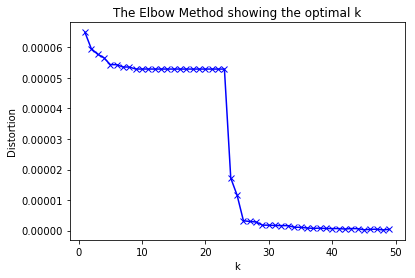

In [658]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
plt.savefig('elbow.png')

In [659]:
kmeans = KMeans(n_clusters= 30).fit(X_kmeans)
kmeans_assign = kmeans.labels_

In [660]:
kmeans_df = pd.DataFrame(np.asarray([temp2.index, kmeans_assign]).T,columns = ['nodes','kmeans'])

In [661]:
assign_all = pd.merge(temp,kmeans_df, how='inner', on='nodes').set_index('nodes')
assign_all.to_csv('assign.csv')

In [662]:
assign_all.head()

,ml_member,info_member,wt_member,fg_member,lp_member,kmeans
nodes,,,,,,
aaa,1,469,258,305,1,25
aah,2,463,164,306,2,0
aaj,387,161,253,63,3,0
aaq,348,1,259,47,4,27
aau,234,351,258,43,5,3
